In [16]:
# Import libraries
!pip install catboost

import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
import seaborn as sns
from pathlib import Path
import numpy as np
import matplotlib

# Connect to Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# Load the data
fatigue_df = pd.read_csv('/content/drive/MyDrive/Datasets/Carbon_Torsion_PI.csv')
fatigue_df

,Heat,Stress (Mpa),Number of Cycles,Temperature (°C),Reduction Ratio,dA,dB,dC,Frequency,Elongation,Reduction of Area,C,Si,Mn,P,S,Ni,Cr,Cu,PI Fatigue Life
0,1,320,28100,550,825,0.05,0.03,0.0,33,23,68,0.35,0.21,0.77,0.021,0.022,0.01,0.01,0.02,3.321334e+04
1,1,320,32100,550,825,0.05,0.03,0.0,33,23,68,0.35,0.21,0.77,0.021,0.022,0.01,0.01,0.02,3.321334e+04
2,1,310,90400,550,825,0.05,0.03,0.0,33,23,68,0.35,0.21,0.77,0.021,0.022,0.01,0.01,0.02,6.773490e+04
3,1,310,119000,550,825,0.05,0.03,0.0,33,23,68,0.35,0.21,0.77,0.021,0.022,0.01,0.01,0.02,6.773490e+04
4,1,300,263000,550,825,0.05,0.03,0.0,33,23,68,0.35,0.21,0.77,0.021,0.022,0.01,0.01,0.02,1.413961e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,36,320,88300,650,660,0.06,0.00,0.0,33,23,62,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11,3.969058e+04
374,36,310,117000,650,660,0.06,0.00,0.0,33,23,62,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11,9.258966e+04
375,36,300,144000,650,660,0.06,0.00,0.0,33,23,62,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11,2.220432e+05
376,36,300,321000,650,660,0.06,0.00,0.0,33,23,62,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11,2.220432e+05


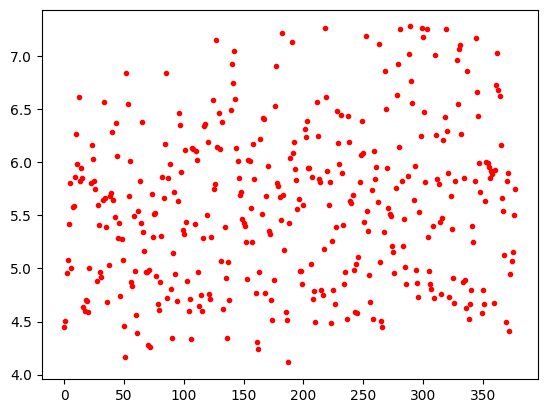

In [18]:
# Sort the data by ascending order of number of cycles
fatigue_df.sort_values(by=['Number of Cycles'], ascending=True, inplace=True)

# Scatter Plot
plt.plot(np.log10(fatigue_df['Number of Cycles']), 'r.')


In [19]:
fatigue_df.columns

Index(['Heat', 'Stress (Mpa)', 'Number of Cycles', 'Temperature (°C)',
       'Reduction Ratio', 'dA', 'dB', 'dC', 'Frequency', 'Elongation',
       'Reduction of Area', 'C', 'Si', 'Mn', 'P', 'S', 'Ni', 'Cr', 'Cu',
       'PI Fatigue Life'],
      dtype='object')

In [20]:
# Remove columns that are not needed
drop_cols = ['Heat','Number of Cycles'] # list the columns to drop along with target for independent feautures

# Use all remaining columns as features
features = fatigue_df.drop(drop_cols, axis=1)

# Use log transform of the number of cycles as targets
targets = np.log10(fatigue_df['Number of Cycles'])

# Display the features
features

,Stress (Mpa),Temperature (°C),Reduction Ratio,dA,dB,dC,Frequency,Elongation,Reduction of Area,C,Si,Mn,P,S,Ni,Cr,Cu,PI Fatigue Life
187,360,550,825,0.10,0.03,0.01,33,22,63,0.44,0.24,0.82,0.021,0.021,0.03,0.02,0.02,1.615986e+04
51,320,550,610,0.07,0.00,0.03,33,21,62,0.26,0.23,0.51,0.018,0.024,0.01,0.02,0.01,8.962672e+03
162,350,550,1270,0.12,0.01,0.00,33,22,66,0.45,0.26,0.76,0.027,0.019,0.01,0.11,0.02,1.778024e+04
72,290,600,1270,0.07,0.02,0.00,33,27,72,0.25,0.18,0.44,0.009,0.017,0.08,0.12,0.08,7.521639e+03
70,280,600,1270,0.07,0.02,0.00,33,27,72,0.25,0.18,0.44,0.009,0.017,0.08,0.12,0.08,3.701477e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,360,550,660,0.06,0.00,0.00,33,55,79,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11,9.787854e+06
319,310,600,1270,0.08,0.01,0.00,33,22,60,0.54,0.26,0.76,0.022,0.021,0.02,0.12,0.01,6.547304e+06
218,290,600,825,0.10,0.03,0.01,33,25,66,0.44,0.24,0.82,0.021,0.021,0.03,0.02,0.02,8.935626e+06
299,350,550,660,0.06,0.00,0.00,33,55,79,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11,4.144169e+07


In [21]:
# Convert the features into floats
features = features.astype('float64')

In [22]:
# Calculate the coverage percentage of values within a specified range
def coverage(y, yL, yH):
        return np.sum(100 / y.shape[0] * ((y>yL)&(y<yH)))

q: 0.025 | pearsonr: 0.4114409151940647
q: 0.5 | pearsonr: 0.8580464654074481
q: 0.975 | pearsonr: 0.6928680762483732
Pearson CC: 0.8580464654074481
R2 score: 0.7329322824855045
RMSE: 0.39730448167715937
MAE: 0.30294031543382655
Coverage: 88.15789473684211
Upper coverage: 94.73684210526315
Lower coverage: 93.42105263157896
Average Interval Width: 2.2022208192743737
Median Interval Width: 2.1653103744983686
Composite Metric: 0.7766410997299789


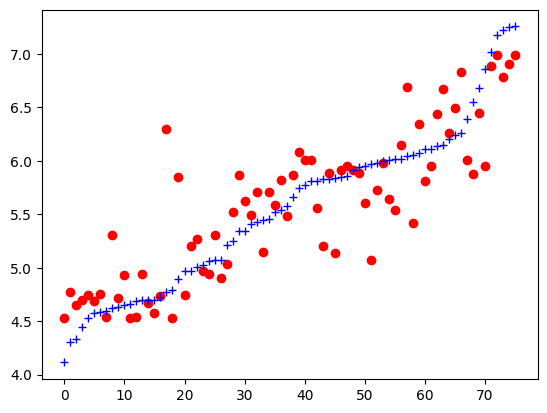

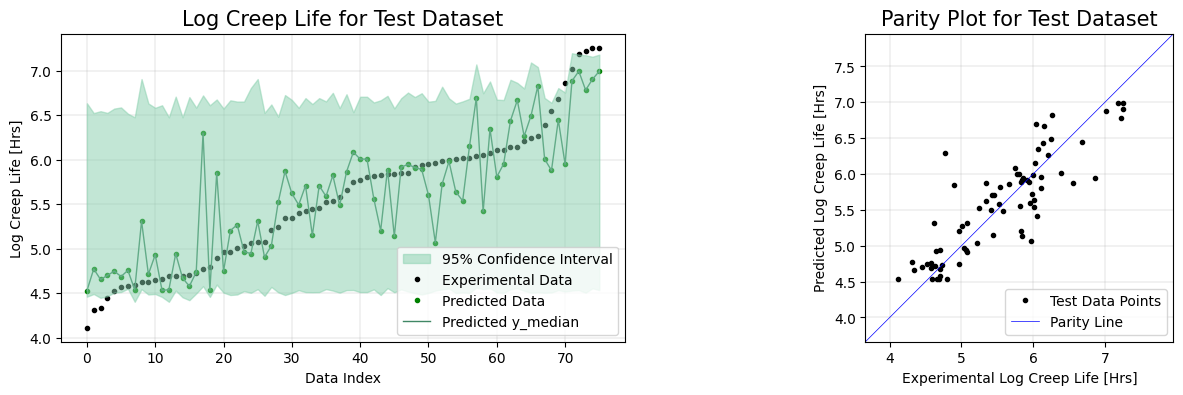

****************************************
q: 0.025 | pearsonr: 0.6890288943365309
q: 0.5 | pearsonr: 0.8910586065356357
q: 0.975 | pearsonr: 0.7982502273575889
Pearson CC: 0.8910586065356357
R2 score: 0.7267755457335421
RMSE: 0.41369495825851854
MAE: 0.3449132061627067
Coverage: 84.21052631578947
Upper coverage: 86.84210526315788
Lower coverage: 97.36842105263158
Average Interval Width: 2.071723719606759
Median Interval Width: 2.0631993906419677
Composite Metric: 0.7527499796660856


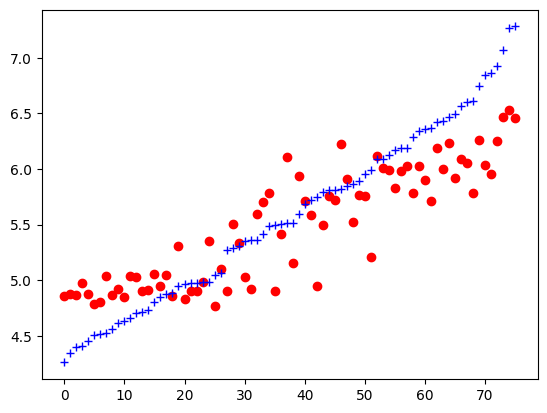

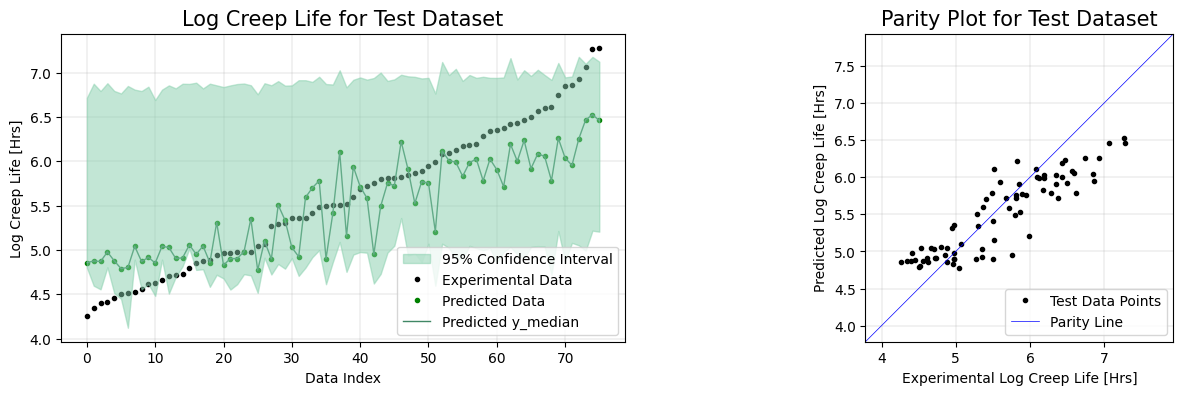

****************************************
q: 0.025 | pearsonr: 0.6616744282240076
q: 0.5 | pearsonr: 0.8441383033505431
q: 0.975 | pearsonr: 0.8145067791140497
Pearson CC: 0.8441383033505431
R2 score: 0.6609062884505841
RMSE: 0.4042997742198834
MAE: 0.3074762181704453
Coverage: 80.26315789473685
Upper coverage: 97.36842105263156
Lower coverage: 82.89473684210526
Average Interval Width: 1.385854301255747
Median Interval Width: 1.3384412108499602
Composite Metric: 0.7887581301565987


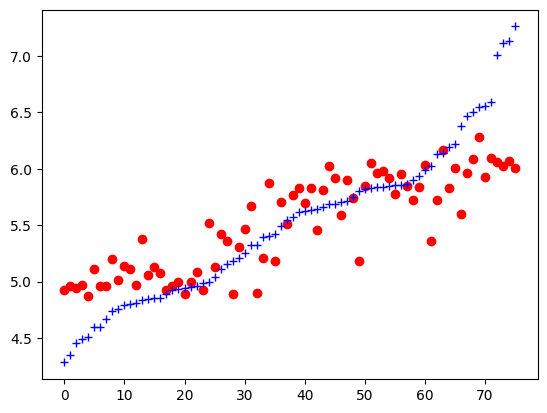

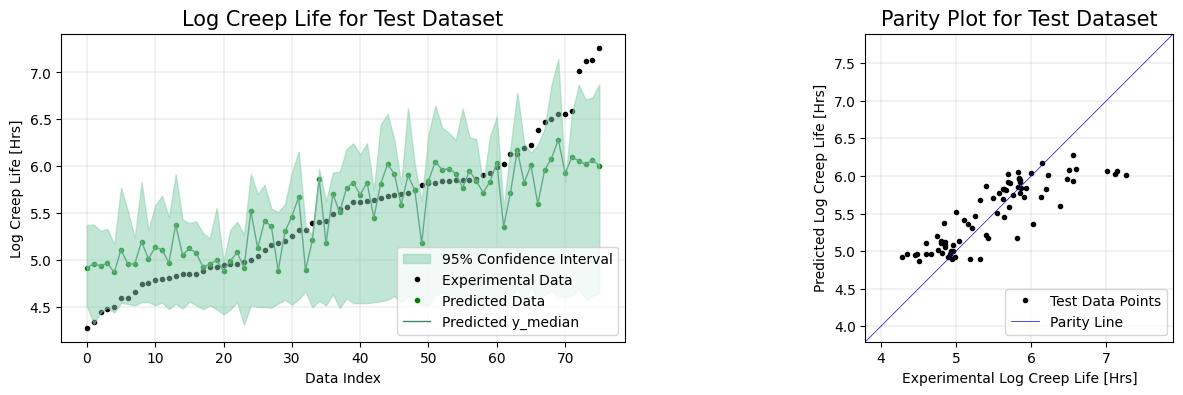

****************************************
q: 0.025 | pearsonr: 0.35921101709289044
q: 0.5 | pearsonr: 0.8362219468911642
q: 0.975 | pearsonr: 0.5881678708929526
Pearson CC: 0.8362219468911642
R2 score: 0.6719680347343949
RMSE: 0.41770266899209985
MAE: 0.31819118963090726
Coverage: 85.33333333333333
Upper coverage: 97.33333333333331
Lower coverage: 88.0
Average Interval Width: 1.9194148344639959
Median Interval Width: 1.9193390824560792
Composite Metric: 0.7702531701069141


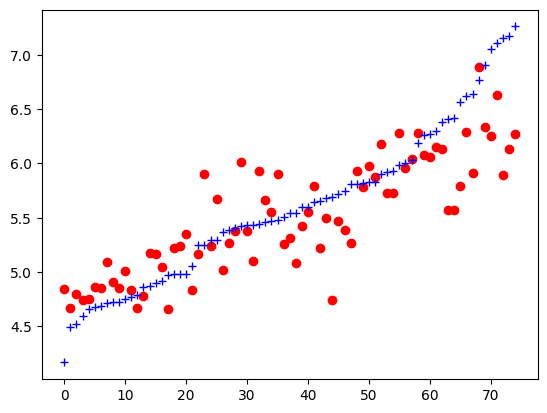

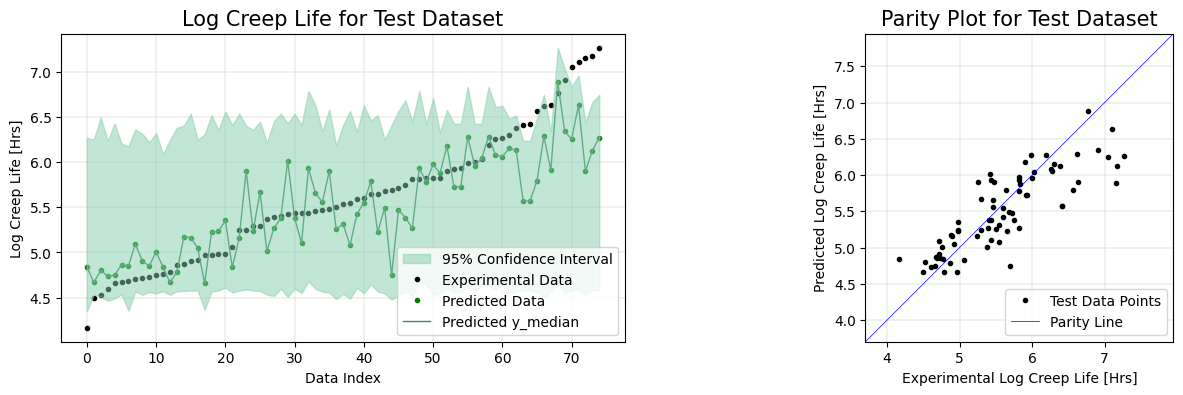

****************************************
q: 0.025 | pearsonr: 0.6633985121856951
q: 0.5 | pearsonr: 0.8066706302709684
q: 0.975 | pearsonr: 0.29282609762776796
Pearson CC: 0.8066706302709684
R2 score: 0.6377711496356071
RMSE: 0.42291685434562387
MAE: 0.34457964499386945
Coverage: 85.33333333333331
Upper coverage: 93.33333333333331
Lower coverage: 91.99999999999999
Average Interval Width: 1.8508469030223735
Median Interval Width: 1.8521519558428619
Composite Metric: 0.7749781259638775


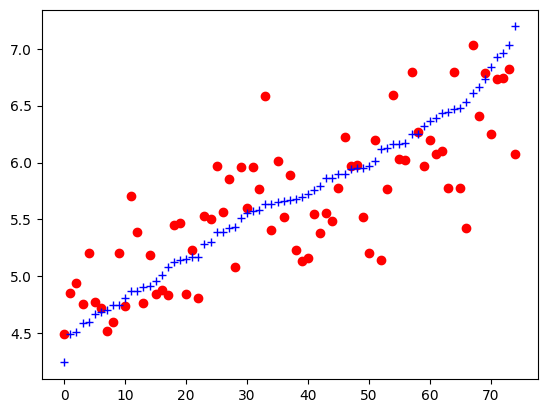

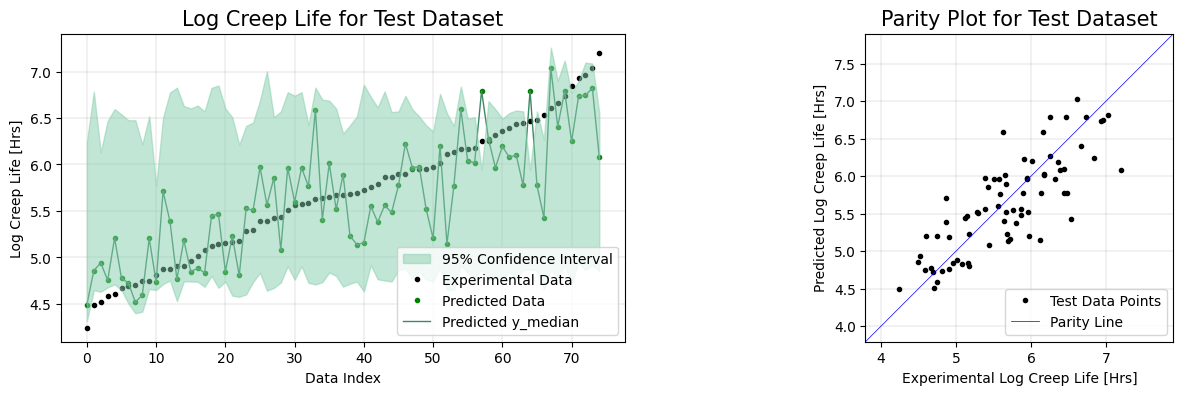

****************************************


In [23]:
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

# Metrics for performance evaluation
PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)
MAPE = np.zeros_like(PearsonCC)

test_coverage = np.zeros_like(PearsonCC)
upper_coverage = np.zeros_like(PearsonCC)
lower_coverage = np.zeros_like(PearsonCC)
mean_interval_width = np.zeros_like(PearsonCC)
median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)

quantiles = [0.025, 0.5, 0.975]

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=66+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):
                X_train, X_test = features.iloc[tr], features.iloc[ts]
                scale = StandardScaler()
                X_train = scale.fit_transform(X_train)
                X_test = scale.transform(X_test)
                y_train, y_test = targets.iloc[tr], targets.iloc[ts]
                X_train, X_val, y_train, y_val = train_test_split(
                        X_train, y_train, test_size=0.1)

                for q in quantiles:
                        parameters = {'loss_function': 'Quantile:alpha={:0.2f}'.format(q),
                                'num_boost_round': 5000}
                        model = CatBoostRegressor(**parameters)
                        model.fit(X_train, np.log(y_train),
                                eval_set=[(X_val, np.log(y_val))],
                                early_stopping_rounds=20,
                                verbose=False)
                        y_pred = np.exp(model.predict(X_test))
                        print(f'q: {q} | pearsonr: {pearsonr(y_test, y_pred)[0]}')
                        if q==0.025:
                           y_low = y_pred
                        elif q==0.5:
                                y_median = y_pred
                        elif q==0.975:
                               y_high = y_pred

                # Plot the predictions
                iteration_list = [i for i in range(len(y_test))]
                plt.plot(iteration_list, y_median, 'ro')
                plt.plot(iteration_list, y_test, 'b+')

                PearsonCC[j, i] = pearsonr(np.squeeze(y_test), np.squeeze(y_median))[0]
                R2_score[j, i] = r2_score(y_test, y_median)
                RMSE[j, i] = np.sqrt(mean_squared_error(y_test, y_median))
                MAE[j, i] = np.mean(abs(y_median-np.array(y_test)))

                print(f'Pearson CC: {PearsonCC[j, i]}')
                print(f'R2 score: {R2_score[j, i]}')
                print(f'RMSE: {RMSE[j, i]}')
                print(f'MAE: {MAE[j, i]}')

                test_coverage[j, i] = coverage(y_test, y_low, y_high)
                upper_coverage[j, i] = coverage(y_test, y_low, np.inf)
                lower_coverage[j, i] = coverage(y_test, -np.inf, y_high)

                print(f'Coverage: {test_coverage[j, i]}')
                print(f'Upper coverage: {upper_coverage[j, i]}')
                print(f'Lower coverage: {lower_coverage[j, i]}')

                # Prediction interval width
                mean_interval_width[j, i] = np.mean(y_high - y_low)
                print(f'Average Interval Width: {mean_interval_width[j, i]}')
                median_interval_width[j, i] = np.median(y_high - y_low)
                print(f'Median Interval Width: {median_interval_width[j, i]}')

                # Composite metric that combines the coverage and the invers of interval width
                composite_metric[j, i] = 0.75*test_coverage[j, i]/100 + 0.25*(1/median_interval_width[j, i])
                print(f'Composite Metric: {composite_metric[j, i]}')

                # Plot the predictions
                fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

                ## Uncertainty quantification plot
                ax[0].fill_between(iteration_list, y_low, y_high, alpha=0.5, color='#86cfac', zorder=5, label='95% Confidence Interval')
                ax[0].plot(iteration_list, y_test, 'ko', markersize=3, label="Experimental Data")
                ax[0].plot(iteration_list, y_median, 'go', markersize=3, label="Predicted Data")
                ax[0].plot(iteration_list, y_median, '-', linewidth=1, color="#408765", label="Predicted y_median")
                ax[0].legend(loc=4, fontsize=10, frameon=True)
                ax[0].set_xlabel("Data Index", fontsize=10)
                ax[0].set_ylabel("Log Creep Life [Hrs]", fontsize=10)
                ax[0].set_title("Log Creep Life for Test Dataset", fontsize=15)
                ax[0].grid(True, which='major', linestyle='-', linewidth='0.25')

                ## Parity Plot
                # find the boundaries of y_test and y_pred(y_median) values
                bounds = (min(y_test.min(), y_median.min()) - 0.1*y_median.min(), max(y_test.max(), y_median.max())+ 0.1 * y_median.max())
                ax[1].plot(y_test, y_median, 'ko', markersize=3, label="Test Data Points")
                ax[1].legend(loc=4, fontsize=10, frameon=False)
                ax[1].plot([bounds[0], bounds[1]], [bounds[0], bounds[1]],'b-', linewidth=0.5, label="Parity Line") # identity line
                ax[1].legend(loc=4, fontsize=10, frameon=True)
                ax[1].set_xlabel("Experimental Log Creep Life [Hrs]", fontsize=10)
                ax[1].set_ylabel("Predicted Log Creep Life [Hrs]", fontsize=10)
                ax[1].set_title("Parity Plot for Test Dataset", fontsize=15)
                ax[1].grid(True, which='major', linestyle='-', linewidth='0.25')
                ax[1].set_xlim(bounds)
                ax[1].set_ylim(bounds)
                ax[1].set_aspect("equal", adjustable="box") # Square aspect ratio

                plt.show()
                print(40*'*')

In [24]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE
0,0.858046,0.732932,0.397304,0.302940
1,0.891059,0.726776,0.413695,0.344913
2,0.844138,0.660906,0.404300,0.307476
3,0.836222,0.671968,0.417703,0.318191
4,0.806671,0.637771,0.422917,0.344580


In [25]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)
MAPE_mean = np.mean(MAPE)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)
MAPE_std = np.std(MAPE)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   },index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std
0,0.847227,0.027618,0.686071,0.037464,0.411184,0.009236,0.32362,0.017947


In [26]:
# Data frame
df3 = pd.DataFrame({'Coverage': test_coverage.flatten(), 'Upper Coverage': upper_coverage.flatten(), 'Lower Coverage': lower_coverage.flatten(),
                    'Mean Interval Width': mean_interval_width.flatten(), 'Median Interval Width': median_interval_width.flatten(), 'Composite Metric': composite_metric.flatten()},index=None)
df3

,Coverage,Upper Coverage,Lower Coverage,Mean Interval Width,Median Interval Width,Composite Metric
0,88.157895,94.736842,93.421053,2.202221,2.165310,0.776641
1,84.210526,86.842105,97.368421,2.071724,2.063199,0.752750
2,80.263158,97.368421,82.894737,1.385854,1.338441,0.788758
3,85.333333,97.333333,88.000000,1.919415,1.919339,0.770253
4,85.333333,93.333333,92.000000,1.850847,1.852152,0.774978


In [27]:
# Calculate mean values and standard deviations of the scores
test_coverage_mean = np.mean(test_coverage)
upper_coverage_mean = np.mean(upper_coverage)
lower_coverage_mean = np.mean(lower_coverage)
mean_interval_width_mean = np.mean(mean_interval_width)
median_interval_width_mean = np.mean(median_interval_width)
composite_metric_mean = np.mean(composite_metric)

test_coverage_std = np.std(test_coverage)
upper_coverage_std = np.std(upper_coverage)
lower_coverage_std = np.std(lower_coverage)
mean_interval_width_std = np.std(mean_interval_width)
median_interval_width_std = np.std(median_interval_width)
composite_metric_std = np.std(composite_metric)

# Data frame
df4 = pd.DataFrame({'Coverage Mean': test_coverage_mean, 'Coverage Std': test_coverage_std, 'Upper Coverage Mean': upper_coverage_mean, 'Upper Coverage Std': upper_coverage_std,
                  'Lower Coverage Mean': lower_coverage_mean, 'Lower Coverage Std': lower_coverage_std,
                    'Mean Interval Width Mean': mean_interval_width_mean, 'Mean Interval Width Std':mean_interval_width_std,
                    'Median Interval Width Mean': median_interval_width_mean, 'Median Interval Width Std':median_interval_width_std,
                   'Composite Metric Mean': composite_metric_mean, 'Composite Metric Std': composite_metric_std,},index=[0])
df4

,Coverage Mean,Coverage Std,Upper Coverage Mean,Upper Coverage Std,Lower Coverage Mean,Lower Coverage Std,Mean Interval Width Mean,Mean Interval Width Std,Median Interval Width Mean,Median Interval Width Std,Composite Metric Mean,Composite Metric Std
0,84.659649,2.556414,93.922807,3.863947,90.736842,4.934923,1.886012,0.278204,1.867688,0.286292,0.772676,0.011684
